## 1. ADIABATIC FLAME - A freely-propagating, premixed flat flame 

In [1]:
import cantera as ct
import numpy as np
from matplotlib.pylab import *

In [2]:
gas = ct.Solution('BFER_methane.yaml', 'CH4_BFER_mix')                # Import gas phases with mixture transport model
# General
p = 1e5                                         # pressure
tin = 600.0                                     # unburned gas temperature
phi = 0.8                                       # equivalence ratio
fuel = {'CH4': 1}                               # Methane composition
oxidizer = {'O2': 1, 'N2': 3.76}                # Oxygen composition
gas.TP = tin, p
gas.set_equivalence_ratio(phi, fuel, oxidizer)

# Get properties
density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s
cp = gas.cp

species_names = gas.species_names
molar_masses = gas.molecular_weights/1000  # Molar masses in kg/mol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y
mol_frac = gas.X

print(gas())
print("-------------------------------------------------------")
print(f"Density (rho_0):\t {density:.4e} kg/m³")
print(f"Kine Visc (nu_0):\t {kinematic_viscosity:.4e} m²/s")
print(f"cp: \t\t\t{cp:.2f} ")
print(f"Therm Cond:(lambda)\t {thermal_conductivity:.4e} W/m/K\n\n")

print(gas.species_names)


  CH4_BFER_mix:

       temperature   600 K
          pressure   1e+05 Pa
           density   0.55843 kg/m^3
  mean mol. weight   27.858 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        1.2635e+05        3.5199e+06  J
   internal energy            -52724       -1.4688e+06  J
           entropy            7951.8        2.2152e+05  J/K
    Gibbs function       -4.6447e+06       -1.2939e+08  J
 heat capacity c_p            1156.9             32229  J/K
 heat capacity c_v            858.43             23914  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2            0.2226            0.1938           -27.037
               CH4          0.044642          0.077519           -40.885
                N2           0.73276           0.72868           -24.0

In [3]:
print("#name     Molar Mass")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {molar_masses[i]:.6f}")    
    
print("\n\n#    Initial mass fractions (FLOW)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions[i]:.6f}", end="    " if i % 2 == 0 else "\n")

print("\n#    Initial diffusion coefficients (FLOW)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs[i]:.4e}", end="    " if i % 2 == 0 else "\n")

#name     Molar Mass
O2     0.031998
H2O    0.018015
CH4    0.016043
CO     0.028010
CO2    0.044009
N2     0.028014


#    Initial mass fractions (FLOW)
O2     0.222598    H2O    0.000000
CH4    0.044642    CO     0.000000
CO2    0.000000    N2     0.732760

#    Initial diffusion coefficients (FLOW)
O2     6.8083e-05    H2O    8.5784e-05
CH4    7.8947e-05    CO     6.9644e-05
CO2    5.5539e-05    N2     7.0552e-05


In [4]:
f = ct.FreeFlame(gas, width=0.02)   # Create the free laminar premixed flame specifying the width of the grid
f.inlet.X = gas.X                   # Inlet condition on mass fraction
f.inlet.T = gas.T                   # Inlet condition on temperature

### 1.2 Program starts here

#### First flame

In [13]:
f.energy_enabled = False                       # No energy for starters

tol_ss = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for steady-state problem
tol_ts = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for time stepping

f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts)

# Set calculation parameters
#f.set_max_jac_age(50, 50)                           # Maximum number of times the Jacobian will be used before it 
                                                    # must be re-evaluated
f.set_time_step(1.0e-8, [2, 5, 10, 20, 40,80,160])         # Set time steps (in seconds) whenever Newton convergence fails 
f.set_refine_criteria(ratio=10.0, slope=1, curve=1) # Refinement criteria

# Calculation
loglevel = 1                                        # amount of diagnostic output (0 to 5)
refine_grid = 'disabled'                            # 'refine' or 'remesh' to enable refinement
                                                    # 'disabled' to disable
f.solve(loglevel, refine_grid)                                      # solve the flame on the grid
f.save('ch4_adiabatic.csv', 'no energy','solution with no energy')  # save solution


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps      2.25e-08      1.209
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     1.709e-07      1.112
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.232e-06     0.2527
Attempt Newton solution of steady-state problem...    failure. 
Take 20 timesteps     0.0006826     -0.276
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
no new points needed in flame
Solution saved to file ch4_adiabatic.csv as solution no energy.


#### Second flame

In [14]:
%%capture
f.energy_enabled = True                                 # Energy equation enabled
refine_grid = 'disabled'                                # 'refine' # Calculation and save of the results
f.set_refine_criteria(ratio=3.0, slope=0.05, curve=0.05)  # Refinement criteria when energy equation is enabled

f.solve(loglevel, refine_grid)
f.save('ch4_adiabatic.csv', 'energy', 'solution with the energy equation enabled')

In [15]:
print('mixture-averaged flamespeed = {0:7f} m/s'.format(f.velocity[0]))  # m/s

mixture-averaged flamespeed = 1.074695 m/s


#### Third flame and so on ...

In [16]:
%%capture
f.set_refine_criteria(ratio=2.0, slope=0.05, curve=0.05) # Refinement criteria should be changed ...

f.solve(loglevel, refine_grid)                           
f.save('ch4_adiabatic.csv', 'energy continuation','solution with the energy equation enabled continuation')

In [17]:
points = f.flame.n_points
print('mixture-averaged flamespeed continuation = {0:7f} m/s'.format(f.velocity[0]))  # m/s
print('mixture-averaged final T = {0:7f} K'.format(f.T[points - 1]))  # K

mixture-averaged flamespeed continuation = 1.074228 m/s
mixture-averaged final T = 2222.634923 K


#### Fourth flame and so on ...

In [18]:
%%capture

f.transport_model = 'Multi'      # Switch transport model

f.solve(loglevel, refine_grid)

f.save('ch4_adiabatic.csv', 'energy_multi',
       'solution with the multicomponent transport and energy equation enabled')

In [19]:
points = f.flame.n_points
print('multicomponent flamespeed = {0:7f} m/s'.format(f.velocity[0]))  # m/s
print('multicomponent final T = {0:7f} K'.format(f.T[points - 1]))  # K

multicomponent flamespeed = 1.097062 m/s
multicomponent final T = 2223.332803 K


You may notice that there are small differences on the flamespeed and on the final temperature between the two transport models, as it was predictable.

### 1.3 Manipulate the results

#### Save your results

In [20]:
f.write_csv('ch4_adiabatic.csv', quiet=False)  # Write the velocity, temperature, density, and mole fractions 
                                               # to a CSV file

Solution saved to 'ch4_adiabatic.csv'.


#### Plot your results (temperature, density, velocity, ...)

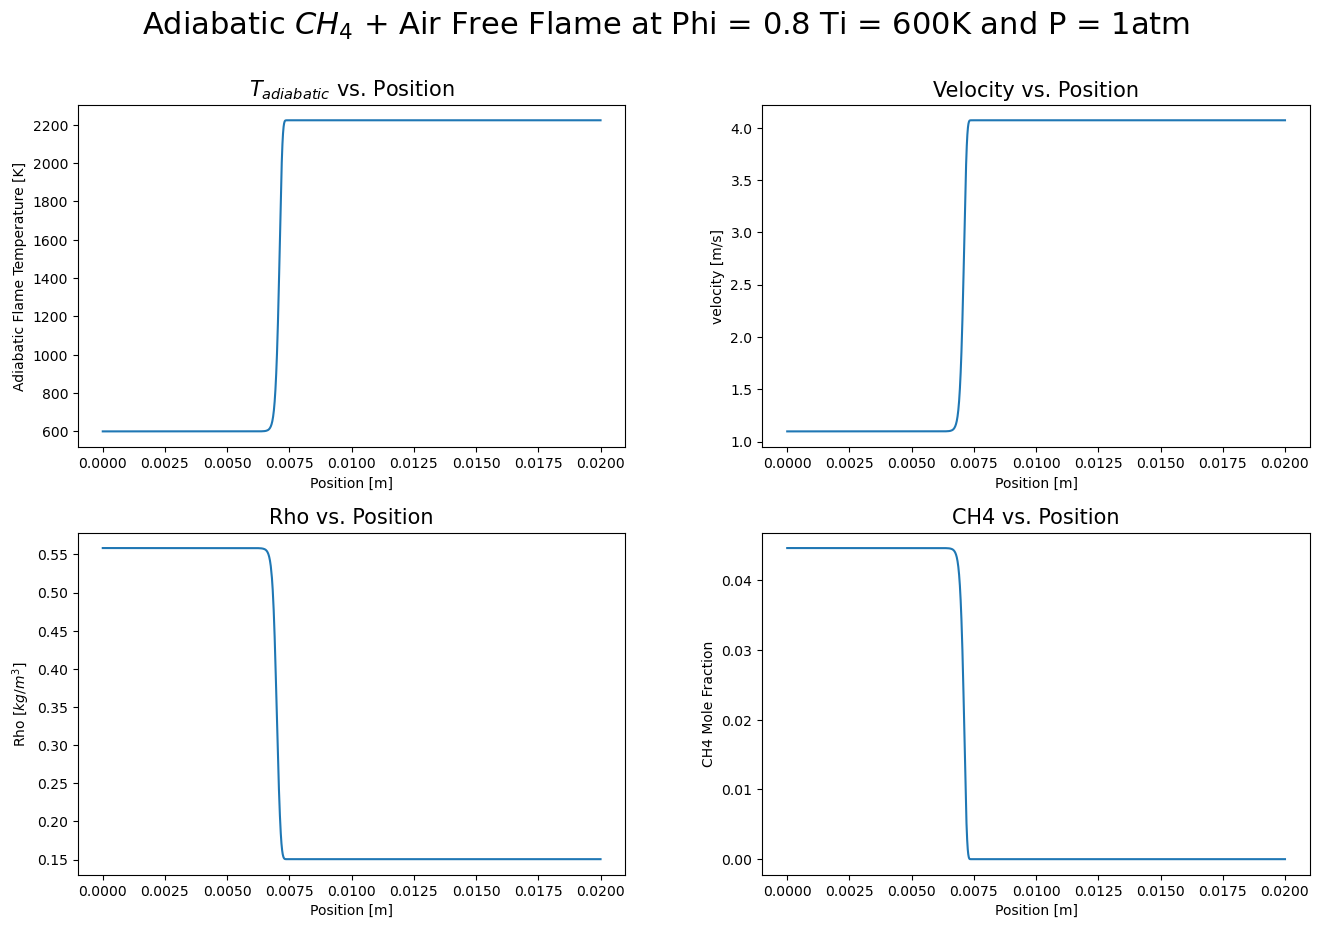

In [21]:
rcParams['figure.figsize'] = (14, 10)

# Get the different arrays
z = f.flame.grid
T = f.T
u = f.velocity
ifuel = gas.species_index('CH4')

fig=figure(1)

# create first subplot - adiabatic flame temperature
a=fig.add_subplot(221)
a.plot(z,T)
title(r'$T_{adiabatic}$ vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("Adiabatic Flame Temperature [K]")
a.xaxis.set_major_locator(MaxNLocator(10)) # this controls the number of tick marks on the axis

# create second subplot - velocity
b=fig.add_subplot(222)
b.plot(z,u)
title(r'Velocity vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("velocity [m/s]")
b.xaxis.set_major_locator(MaxNLocator(10)) 

# create third subplot - rho
c=fig.add_subplot(223)
p = zeros(f.flame.n_points,'d')
for n in range(f.flame.n_points):
    f.set_gas_state(n)
    p[n]= gas.density_mass
c.plot(z,p)
title(r'Rho vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("Rho [$kg/m^3$]")
c.xaxis.set_major_locator(MaxNLocator(10)) 


# create fourth subplot - specie CH4
d=fig.add_subplot(224)
ch4 = zeros(f.flame.n_points,'d')
for n in range(f.flame.n_points):
    f.set_gas_state(n)
    ch4[n]= gas.Y[ifuel]
d.plot(z,ch4)
title(r'CH4 vs. Position', fontsize=15)
xlabel(r'Position [m]')
ylabel("CH4 Mole Fraction")
d.xaxis.set_major_locator(MaxNLocator(10))

# Set title
fig.text(0.5,0.95,r'Adiabatic $CH_{4}$ + Air Free Flame at Phi = 0.8 Ti = 600K and P = 1atm',fontsize=22,horizontalalignment='center')

subplots_adjust(left=0.08, right=0.96, wspace=0.25, hspace=0.25)

<div class="alert alert-danger "><b> The plots here describe the flame front. The evolution of the variables and the different values seem coherent with the simulation.  </b></div>

## 2. A burner-stabilized rich premixed methane-oxygen flame at low pressure

<p class="bg-primary" style="padding:1em"> This script will show you the creation of a burner. This is basically the same thing as a premixed flame, except that the flame is stabilized on a burner and not freely proapagating. </p> 

![title](Images/burnervsfree.pdf)
From R.J. Kee, M.E. Coltrin and P. Glarborg *Chemically Reacting Flow*

### 2.1 Initial solution

<div class="alert alert-danger "><b> Try to set a solution from :<br>
- the gri30 mechanism (CH4/air flame) <br>
- with a pressure of 1 bar, a temperature of 373 K, an equivalence ratio of 1.3
<b></div>

In [ ]:
# Import gas phases with mixture transport model
gas = ct.Solution('gri30.yaml')

# Parameter values :
# General
p = 1e5  # pressure
tin = 373  # unburned gas temperature
phi = 1.3

fuel = 'CH4: 1'
oxidizer = 'O2:1.0, N2:3.76'

# Set gas state to that of the unburned gas
gas.TP = tin, p
gas.set_equivalence_ratio(phi, fuel, oxidizer)

<div class="alert alert-danger "><b> Try to construct a BurnerFlame of width 2 cm and implement the limit conditions (f.burner instead of f.inlet for this case).
<b></div>

In [ ]:
f = ct.BurnerFlame(gas, width=0.2)

f.burner.T =  gas.T
f.burner.X =  gas.X              # Conditions

mdot = 0.04   
f.burner.mdot = mdot

In [ ]:
f.grid

In [ ]:
#%%capture
#################
#f.energy_enabled = False

tol_ss = [1.0e-5, 1.0e-9]  # [rtol atol] for steady-state
tol_ts = [1.0e-5, 1.0e-4]  # [rtol atol] for time stepping

f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts)

f.set_refine_criteria(ratio=10.0, slope=1, curve=1)

f.set_max_jac_age(50, 50)

f.set_time_step(1.0e-5, [1, 2, 5, 10, 20])

loglevel = 1  # amount of diagnostic output (0 to 5)

#refine_grid = 'refine'  # True to enable refinement, False to

#f.solve(loglevel, refine_grid)

#f.save('ch4_burner_flame.csv', 'no_energy',
#       'solution with the energy equation disabled')

#################
f.energy_enabled = True

f.set_refine_criteria(ratio=3.0, slope=0.1, curve=0.2)

#f.solve(loglevel, refine_grid='refine')

#f.save('ch4_burner_flame.csv', 'energy',
#       'solution with the energy equation enabled')

#################
f.transport_model = 'Multi'

#f.solve(loglevel, refine_grid='refine')

#f.save('ch4_burner_flame.csv', 'energy_multi',
#       'solution with the energy equation enabled and multicomponent transport')

#################
f.soret_enabled = True

f.solve(loglevel, refine_grid='refine')

f.save('ch4_burner_flame.csv', 'energy_soret',
       'solution with the energy equation enabled and multicomponent transport')


<div class="alert alert-danger "><b> Here the plot is for the temperature. Try to change it to plot the laminar flame speed.
<b></div>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f.grid, f.velocity)
plt.xlabel('grid (m)',fontsize=15)
plt.ylabel('Laminar flame speed ($m/s$)',fontsize=15)
plt.title('Laminar flame speed vs x-axis for an equivalence ratio of 1.3', fontsize=20)
plt.show()

f.write_csv('ch4_burner_flame.csv', quiet=True)

In [ ]:
gas = ct.Solution('gri30.yaml', 'gri30')

p = 1e5  # pressure

comp_f = 'C2H6:1'                       # fuel composition
tin_f = 300.0                           # fuel inlet temperature

rho_f = p / (8.314 / 0.030 * tin_f)     # fuel inlet density
mdot_f = 0.24                           # fuel inlet mass flow rate (kg/m^2/s)
vel_f = mdot_f / rho_f                  # fuel inlet velocity
print('Velocity of the fuel : ' + str(vel_f))

comp_o = 'O2:0.21, N2:0.78, AR:0.01'    # oxidizer composition
tin_o = 300.0                           # oxidizer inlet temperature

rho_o = p / (8.314 / 0.029 * tin_o)     # oxidizer inlet density
mdot_o = 0.72                           # oxidizer inlet mass flow rate (kg/m^2/s)
vel_o = mdot_o / rho_o                  # oxidizer inlet velocity
print('Velocity of the oxidizer : ' + str(vel_o))

gas.TP = tin_o, p

width = 0.02
a = (vel_o + vel_f) / width              # calculation of the strain rate (s^-1)
print('Strain rate of the diffusion flame : ' + str(a))

In [ ]:
initial_grid = np.linspace(0, width, 6)
f = ct.CounterflowDiffusionFlame(gas, initial_grid)

# Set the state of the two inlets
f.fuel_inlet.mdot = mdot_f
f.fuel_inlet.X = comp_f
f.fuel_inlet.T = tin_f

f.oxidizer_inlet.mdot = mdot_o
f.oxidizer_inlet.X = comp_o
f.oxidizer_inlet.T = tin_o

In [ ]:
#%%capture
# First flame:
# disable the energy equation
f.energy_enabled = False

# Set error tolerances
tol_ss = [1.0e-5, 1.0e-11]  # [rtol, atol] for steady-state problem
tol_ts = [1.0e-5, 1.0e-11]  # [rtol, atol] for time stepping
f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts)

# and solve the problem without refining the grid
f.solve(loglevel=1, refine_grid='disabled')

#################
# Second flame:
# specify grid refinement criteria, turn on the energy equation,
f.energy_enabled = True

f.set_refine_criteria(ratio=3, slope=0.8, curve=0.8)

# and solve the problem again
f.solve(loglevel=1, refine_grid='refine')

# save your results
f.save('c2h6_diffusion.csv', 'energy')

#################
# Third flame:
# specify grid refinement criteria, turn on the energy equation,
f.energy_enabled = True

f.set_refine_criteria(ratio=2, slope=0.2, curve=0.2, prune=0.04)

# and solve the problem again
f.solve(loglevel=1, refine_grid='refine')

# save your results
f.save('c2h6_diffusion.csv', 'energy continuation')

#################################################################
# Save your results if needed
#################################################################
# write the velocity, temperature, and mole fractions to a CSV file
f.write_csv('c2h6_diffusion.csv', quiet=False)

In [ ]:
# Get interesting values
z = f.flame.grid
T = f.T
u = f.velocity

# Get interesting indices for computation of species
fuel_species = 'C2H6'
ifuel = gas.species_index(fuel_species)
io2 = gas.species_index('O2')
in2 = gas.species_index('N2')

# Initiate interesting vectors
c2h6 = np.zeros(f.flame.n_points,'d')
o2 = np.zeros(f.flame.n_points,'d')
hr = np.zeros(f.flame.n_points,'d')

# Computes interesting quantities for analyzing a counter-flow flame
for n in range(f.flame.n_points):
    f.set_gas_state(n)
    c2h6[n]= gas.Y[ifuel]
    o2[n]= gas.Y[io2]
    hr[n] = - np.dot(gas.net_production_rates, gas.partial_molar_enthalpies)

In [ ]:
fig=figure(1)

a=fig.add_subplot(111)
a.plot(z,T/np.max(T),z,c2h6/np.max(c2h6),z,o2/np.max(o2))
plt.title(r'$T_{adiabatic}$ vs. Position',fontsize=25)
plt.xlabel(r'Position [m]', fontsize=15)
plt.ylabel('Normalized values of different quantities',fontsize=15)
plt.legend(['Temperature','$Y_{C_2H_6}$', '$Y_{O_2}$'],fontsize=15)
show()